In [163]:
import glob
import numpy as np 
from PIL import Image
from itertools import combinations
import os

DATASET_PATH = './dev_dataset/'

In [164]:
images = np.array(sorted(glob.glob(DATASET_PATH+'*.jpg')))

In [165]:
indecies = np.array(list(combinations(range(len(images)),2)))

In [166]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [167]:
def median_image_hashing(image_path, hash_dims=(8,8)):
    '''
    Median image hashing algorithm
    '''
    image_pil = Image.open(image_path)
    resized_im = np.array(image_pil.resize(hash_dims))
    gray_im = rgb2gray(resized_im)
    binarized = (gray_im > np.median(gray_im)).astype(np.uint8)
    average_hash = binarized.flatten()
    return average_hash

In [168]:
def hamming_distance(hash_pair):
    return sum((hash_pair[0]!=hash_pair[1]).astype(np.uint8))

In [7]:
image_hashes = np.array([median_image_hashing(path) for path in images])

In [8]:
hash_pairs = image_hashes[indecies]

In [9]:
distance_values = np.array(list(map(hamming_distance, hash_pairs)))

In [15]:
dup_indecies = np.argwhere(distance_values<=6)

In [16]:
images[indecies[dup_indecies]].reshape(-1,2)

array([['./dev_dataset/1.jpg', './dev_dataset/1_duplicate.jpg'],
       ['./dev_dataset/11.jpg', './dev_dataset/11_duplicate.jpg'],
       ['./dev_dataset/11.jpg', './dev_dataset/11_modification.jpg'],
       ['./dev_dataset/11_duplicate.jpg',
        './dev_dataset/11_modification.jpg'],
       ['./dev_dataset/15.jpg', './dev_dataset/15_modification.jpg']],
      dtype='<U33')

###  Hmm.  Not all of dups were found. Seems that  median hashing is note translation invariant. Let's try out comparing image color distribution. 

# Image histograms

In [169]:
def color_histogram(image_path, bins=20, dims = (50,50)):
    image_pil = Image.open(image_path)
    resized_im = np.array(image_pil.resize(dims))
    gray_im = rgb2gray(resized_im)
    return np.histogram(gray_im,bins=np.linspace(0,255,bins))[0] 

In [170]:
def histogram_intersection(hist_pair):
    minima = np.minimum(hist_pair[0], hist_pair[1])
    intersection = np.true_divide(np.sum(minima), np.sum(hist_pair[1]))
    return intersection 

In [19]:
color_distribution = np.array([color_histogram(path) for path in images])

In [20]:
dist_pairs = color_distribution[indecies]

In [21]:
intersection_values = np.array(list(map(histogram_intersection, dist_pairs)))

In [22]:
dup_indecies = np.argwhere(intersection_values>=.9)

In [23]:
images[indecies[dup_indecies]].reshape(-1,2)

array([['./dev_dataset/1.jpg', './dev_dataset/1_duplicate.jpg'],
       ['./dev_dataset/11.jpg', './dev_dataset/11_duplicate.jpg'],
       ['./dev_dataset/11.jpg', './dev_dataset/11_modification.jpg'],
       ['./dev_dataset/11_duplicate.jpg',
        './dev_dataset/11_modification.jpg'],
       ['./dev_dataset/15.jpg', './dev_dataset/15_modification.jpg'],
       ['./dev_dataset/4.jpg', './dev_dataset/4_similar.jpg'],
       ['./dev_dataset/6.jpg', './dev_dataset/6_similar.jpg']],
      dtype='<U33')

### Yay! All dups seem to be found. I'll combine both of the algorithms just to be on the safe side :)

In [171]:
def find_dups_from_dir(data_dir, hash_threshold=6, hist_threshold=.9):
    
    if not os.path.exists(data_dir):
        print('Bad boy')
        return  
    
    images_filenames = np.array(glob.glob(data_dir+'/*'))
    possible_ind_combs = np.array(list(combinations(range(len(images_filenames)),2)))
    image_hashes = np.array([median_image_hashing(path) for path in images_filenames])
    color_distribution = np.array([color_histogram(path) for path in images_filenames])
    hash_pairs, dist_pairs = image_hashes[possible_ind_combs], color_distribution[possible_ind_combs]
    hamming_distances = np.array(list(map(hamming_distance, hash_pairs)))
    histogram_intersections =  np.array(list(map(histogram_intersection, dist_pairs)))
    
    
    mask1 = hamming_distances<hash_threshold
    mask2 = histogram_intersections>hist_threshold
    final_mask = mask1 | mask2
    dup_ind = np.argwhere(final_mask)
    image_ind = possible_ind_combs[dup_ind]
    
    return np.squeeze(images_filenames[image_ind])

In [41]:
find_dups_from_dir('./dev_dataset/')

array([['./dev_dataset/11_duplicate.jpg', './dev_dataset/11.jpg'],
       ['./dev_dataset/11_duplicate.jpg',
        './dev_dataset/11_modification.jpg'],
       ['./dev_dataset/6_similar.jpg', './dev_dataset/6.jpg'],
       ['./dev_dataset/15.jpg', './dev_dataset/15_modification.jpg'],
       ['./dev_dataset/11.jpg', './dev_dataset/11_modification.jpg'],
       ['./dev_dataset/4.jpg', './dev_dataset/4_similar.jpg'],
       ['./dev_dataset/1.jpg', './dev_dataset/1_duplicate.jpg']],
      dtype='<U33')

# For testing purposes lets try out our algorithm on  another dataset.

## We will apply random affine distortions to some downloaded pictures

In [99]:
TEST_PATH = './Test_images/'
test_images = np.array(glob.glob(TEST_PATH+'*.*'))

In [186]:
images = np.array([np.array(Image.open(file_path).resize((1024, 1024)))
                   for file_path in test_images])

### We'll use keras ImageDataGenerator  for simulating image distortions

In [187]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
%matplotlib inline

In [224]:
generator = ImageDataGenerator(rotation_range=10,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = .5,
                               zoom_range = 0.15,
                               horizontal_flip = True,
                              preprocessing_function = lambda x: x.astype(np.uint8),
                              dtype=np.uint8)

In [227]:
data_gen = generator.flow(images,
                          test_images,
                          seed=21,
                          batch_size=16,
                         shuffle=False)

In [228]:
def plot_figures(figures, nrows=1, ncols=1, figsize=(15, 15)):

    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 15))

    for ind, title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[ind])
        axeslist.ravel()[ind].set_title(ind)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()  # optional
    
def self_balancing_plot(random_identity_pics):
    
    size = len(random_identity_pics)
    nrows = int(round(np.sqrt(size)))
    ncols = int(np.ceil(size/nrows))
    return plot_figures(random_identity_pics,nrows,ncols)

## real pictures

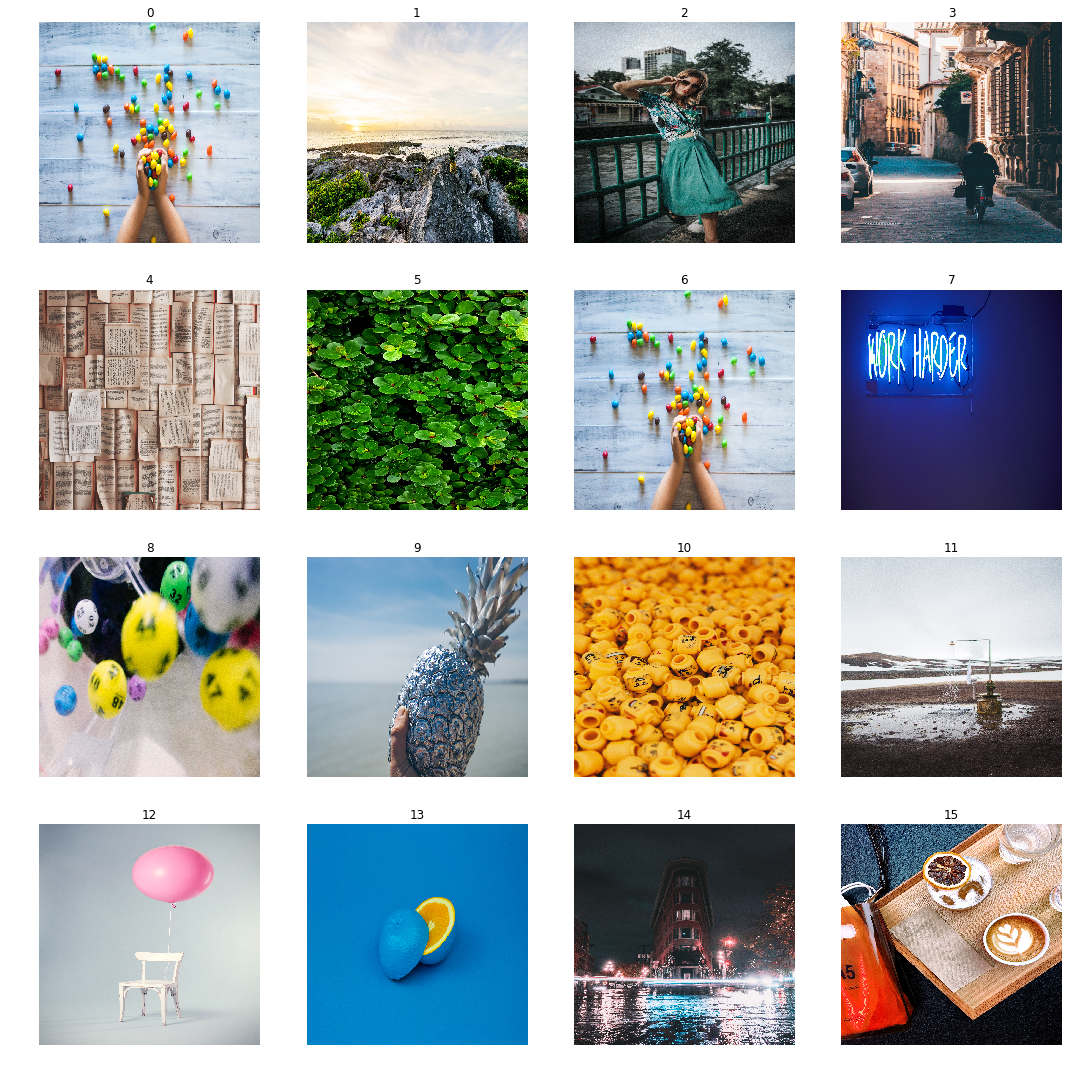

In [229]:
self_balancing_plot(images[:16])

## generated pictures

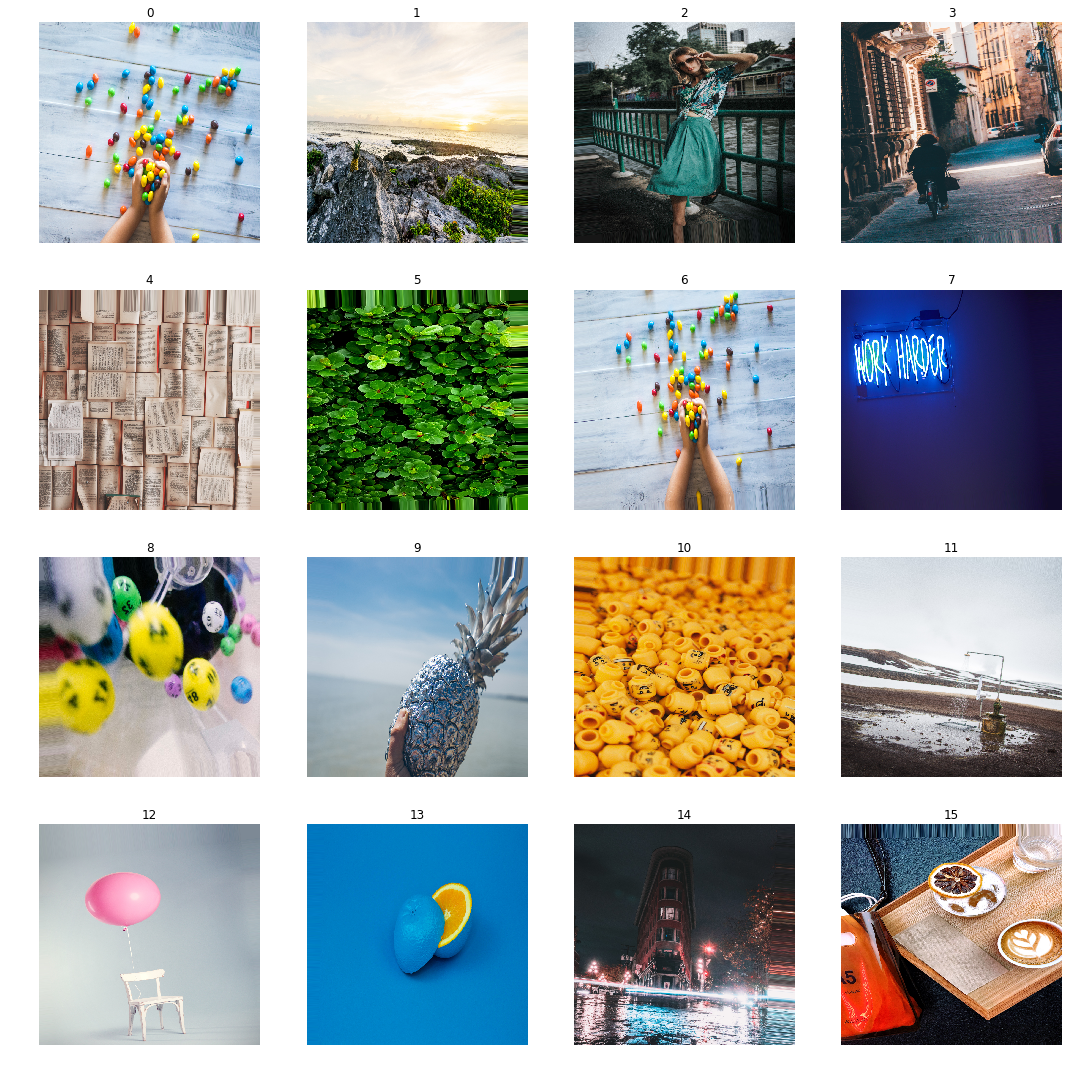

In [230]:
self_balancing_plot(next(data_gen)[0].astype(np.uint8))

In [192]:
def generate_augemnted_images(image, 
                              file_pathes,
                              num_to_generate,
                              write_path = TEST_PATH):
    
    data_gen = generator.flow(images,
                          file_pathes,
                          seed=42,
                          batch_size=num_to_generate)  
    
    
    replace_path = lambda i,x: x.split('.jpg')[0]+str(i)+"_augmented.jpg"

    generated_batch = next(data_gen)
    
    new_images = generated_batch[0]
    old_pathes = generated_batch[1]
    
    for i,(image,path) in enumerate(zip(new_images, old_pathes)):
        new_path  = replace_path(i,path)
        Image.fromarray(image.astype(np.uint8)).save(new_path)

In [193]:
generate_augemnted_images(images, test_images, len(test_images))

In [207]:
dups_found = find_dups_from_dir(TEST_PATH)

In [208]:
dups_found

array([['./Test_images/shivam-dewan-1181118-unsplash32_augmented.jpg',
        './Test_images/shivam-dewan-1181118-unsplash.jpg'],
       ['./Test_images/thibaud-vaerman-36046-unsplash5_augmented.jpg',
        './Test_images/thibaud-vaerman-36046-unsplash.jpg'],
       ['./Test_images/patrick-fore-381122-unsplash (1).jpg',
        './Test_images/patrick-fore-381122-unsplash.jpg'],
       ['./Test_images/patrick-fore-381122-unsplash (1).jpg',
        './Test_images/patrick-fore-381122-unsplash (1)16_augmented.jpg'],
       ['./Test_images/patrick-fore-381122-unsplash (1).jpg',
        './Test_images/patrick-fore-381122-unsplash6_augmented.jpg'],
       ['./Test_images/pineapple-supply-co-253653-unsplash.jpg',
        './Test_images/pineapple-supply-co-253653-unsplash20_augmented.jpg'],
       ['./Test_images/joshua-rawson-harris-781011-unsplash.jpg',
        './Test_images/joshua-rawson-harris-781011-unsplash23_augmented.jpg'],
       ['./Test_images/dan-gold-567166-unsplash27_augmented

In [212]:
def find_false_positives(preds):
    identity_finder = lambda file_path : file_path.split('/')[-1].split('-unsplash')[0]
    names = [(identity_finder(part[0]), identity_finder(part[1])) for part in preds]
    wrong_names = [name for name in names if name[0]!=name[1]]
    return wrong_names

In [213]:
find_false_positives(dups_found)

[('miti-639397', 'sebastiaan-stam-753131')]

In [215]:
len(dups_found)

39

## Seems like all dups are identified (with one false positive though)